In [1]:
import cv2 # computer vision
import numpy as np
import pandas as pd
import os # files 
import matplotlib.pyplot as plt
# from tensorflow.keras.models import load_model
from PIL import Image
# from transformers import BlipProcessor, BlipForConditionalGeneration

In [3]:
# extraction_path = r"D:\HARenv\human detection and people count\extraction_frames"
extraction_path=r"D:\ANACONDA3\envs\HARenv\human detection and people count\frames_HAR"

In [3]:
video_path=r"D:\HARenv\human detection and people count/harr.mp4"
# video_path=r"D:\HARenv\Dataset\sitting\sitting5.mp4"
# Open the video file
cap = cv2.VideoCapture(video_path)

# Get the frames per second (fps) of the video
fps = int(cap.get(cv2.CAP_PROP_FPS))


In [3]:
# Path to the video file
# video_path = r"D:\HARenv\multiPeopleHAR.mp4"
# video_path=r"D:\HARenv\HAR_OFFICE.mp4"

# Define the directory where frames will be saved
# extraction_path = r"D:\HARenv\human detection and people count\extraction_frames"
extraction_path=r"D:\ANACONDA3\envs\HARenv\human detection and people count\frames_HAR"# Initialize frame counter
frame_counter = 1

# Loop through the video frames
while True:
    ret, frame = cap.read()

    if not ret:
        break
    
    # Save the frame with a filename like "frame1.jpg" in the specified directory
    frame_filename = os.path.join(extraction_path, f'frame{frame_counter}.jpg')
    cv2.imwrite(frame_filename, frame)
    
    frame_counter += 1

# Release the video capture object6
cap.release()

print(f"The frames per second (fps) of the video is: {fps}")

The frames per second (fps) of the video is: 30


In [4]:
print(frame_counter)

8121


In [5]:
fps

30

In [6]:
#Duration is
duration=frame_counter/fps
total_time = "{:02}:{:02}:{:02}".format(int(duration // 3600), int((duration // 60) % 60), int(duration % 60))
print(total_time)

00:04:30


# (i) Object Detection and Bounding Boxes

# (ii) Counting People

# (iii) Screen Time Calculation


In [4]:
# yolov3 have single output layer for probability distribution and box predictions.
net = cv2.dnn.readNet('yolov4.weights', 'yolov4.cfg')
# weights - neural network parameters like bias,propagation etcc.
# cfg - configuration , architecture

In [5]:
# extraction_path=r"D:\HARenv\human detection and people count\extraction_frames"
extraction_path=r"D:\ANACONDA3\envs\HARenv\human detection and people count\frames_HAR"

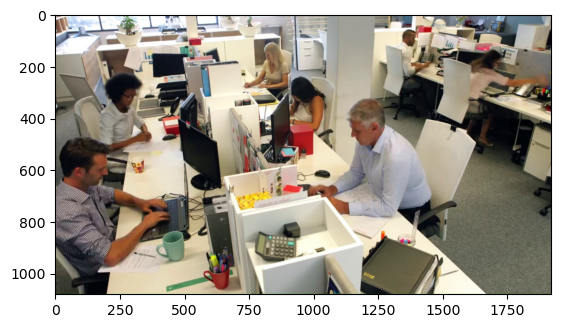

In [6]:
# img = plt.imread(r"D:\HARenv\human detection and people count\extraction_frames\frame20.jpg")   # reading image using its name
# plt.imshow(img)
img = plt.imread(r"D:\ANACONDA3\envs\HARenv\human detection and people count\frames_HAR\frame20.jpg")   # reading image using its name
plt.imshow(img)

In [8]:
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large")

# Human detection

# Counting people

In [ ]:
print(len(printed_person_ids))

# Calculate screen time of each person

In [9]:
current_person_id = 0

printed_person_ids = set()  # to keep track of already printed persons, set is used because of uniqueness
class_ids = []  # 0 for people in the model
data = []  # details of detected persons and their frames
frame_counter = 8200

target_words = ["sitting", "walking", "standing", "writing",'talking','mobile','typing','computer','chatting','leaning']
window_name = "Cropped Person"  # Define the window name

# Create a window and set its properties (you can adjust the size as needed)
cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
cv2.resizeWindow(window_name, 400, 400)
# Load Yolo
classes = []
printed_person_ids = set()  # to keep track of already printed persons, set is used because of uniqueness
class_ids = []  # 0 for people in the model
data = []  # details of detected persons and their frames

# with open("coco.names", "r") as f:
#     classes = [line.strip() for line in f.readlines()]

# layer_names = net.getLayerNames()
# output_layers = []
# for i in net.getUnconnectedOutLayers():
#     output_layers.append(layer_names[i - 1])

# colors = np.random.uniform(0, 255, size=(len(classes), 3))

# person_class_id = classes.index("person")


# Folder containing extracted frames
frame_folder = extraction_path=r"D:\ANACONDA3\envs\HARenv\human detection and people count\frames_HAR"
# Get a list of frame file names in the folder
frame_files = [f for f in os.listdir(frame_folder) if os.path.isfile(os.path.join(frame_folder, f))]
frame_files.sort()  # Sort the frame files

for i in range(1, frame_counter,100):
    frame_path = extraction_path + "\\frame%d.jpg" % i
    image = cv2.imread(frame_path)
    height, width = image.shape[:2]  # first 2 values in the image which is height and width

    # Preprocess the frames for YOLOv3
    blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), swapRB=True, crop=False)
    # A pixel with a value of 0 is completely dark (black), while a pixel with a value of 255 is completely bright (white)
    # 0.00392: This is a scaling factor. It's used to scale pixel values ( adjusting pixel values in an image). In YOLOv4,
    # images are usually preprocessed by dividing pixel values by 255.0, but this factor helps fine-tune the scaling and normalization
    # open cv loads BGR so swapRB=True

    net.setInput(blob)  # sets input for the network

    # Get output
    outs = net.forward(net.getUnconnectedOutLayersNames())
    # outs =    [x1, y1, width1, height1, confidence1, class_id1]... for all layers
    # outs - output layer

    # Thresholds
    conf_threshold = 0
    nms_threshold = 0

    confidences = []
    boxes = []

    # Detection process
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence >= 0 and class_id == 0:
                # Object detected as a person
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                # Rectangle coordinates
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                
    indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.1, 0.1)

    # indices hold the indices of the bounding boxes that represent distinct and confident detections
    current_person_id = 0

    # Draw bounding boxes without tracking
    for index in indices:
        x, y, w, h = boxes[index]
        color = (0, 255, 0)  # Green color
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 3)

        # Increment the person ID
        cropped_person = image[y:y + h, x:x + w]
        current_person_id += 1
        detected_action = None

        try:
            # Pass the cropped image to your caption generation model
            raw_image = cv2.resize(cropped_person, (800, 600))  # Resize the image for better display
            inputs = processor(Image.fromarray(cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)), return_tensors="pt")
            out = model.generate(**inputs)
            caption = processor.decode(out[0], skip_special_tokens=True)

            # # Search for target words in the generated caption
            # for word in target_words:
            #     if word in caption:
            #         detected_action = word
            #         break  # Stop searching once a target word is found

        except cv2.error as e:
            # Handle the error (empty image) here
            print(f"Error resizing ROI: {e}")

        # Store the frame, person ID, and detected action in the list
        # data.append([i, current_person_id, detected_action])
        data.append([i, current_person_id, caption])

        # Print the detected action
        # if detected_action:
        print(f"Frame {i} - Person {current_person_id} is {caption}")
        # else:
            # print(f"Frame {i} - Person {current_person_id} - No specific action detected")

        # Display the cropped person with bounding box
        try:
            cv2.imshow(window_name, raw_image)
        except cv2.error as e:
            # Handle the "size.width>0 && size.height>0" error with an exception
            print(f"Error displaying image: {e}")
    # Display the frame with bounding boxes
    resized_image = cv2.resize(image, (800, 600))
    cv2.imshow("Bounding box", resized_image)

    key = cv2.waitKey(1)
    
    if key == ord('q'):
        break

cv2.destroyAllWindows() 

NameError: name 'processor' is not defined

In [12]:
data

[[1, 1, 'arafed man sitting at a desk with a laptop and a mouse'],
 [1, 2, 'arafed man sitting at a desk with a laptop and a mouse'],
 [1, 3, 'a close up of a person sitting at a desk with a laptop'],
 [1, 4, 'a close up of a woman writing on a piece of paper'],
 [1,
  5,
  'blond woman sitting at a desk with a laptop computer and a green frame'],
 [1, 6, 'a close up of a man sitting at a desk with a computer'],
 [1, 7, 'arafed woman sitting at a desk with a laptop and a phone'],
 [101, 1, 'arafed man sitting at a desk with a laptop and a mouse'],
 [101, 2, 'arafed man sitting at a desk with a laptop and a mouse'],
 [101, 3, 'there is a woman sitting at a desk with a laptop computer'],
 [101, 4, 'a close up of a woman writing on a piece of paper'],
 [101, 5, 'woman sitting at a desk with a laptop computer and a green screen'],
 [101, 6, 'a close up of a man sitting at a desk with a computer'],
 [101, 7, 'arafed woman sitting at a desk with a phone and a laptop'],
 [201, 1, 'arafed man 

In [13]:
df = pd.DataFrame(data)

In [14]:
df.to_csv('HAR_and_detection.csv', index=False)

In [3]:
data = pd.read_csv('HAR_and_detection.csv')

In [4]:
data

,0,1,2
0,1,1,arafed man sitting at a desk with a laptop and...
1,1,2,arafed man sitting at a desk with a laptop and...
2,1,3,a close up of a person sitting at a desk with ...
3,1,4,a close up of a woman writing on a piece of paper
4,1,5,blond woman sitting at a desk with a laptop co...
...,...,...,...
457,8101,1,there is a man sitting at a table writing on a...
458,8101,2,woman in white dress bending over to pick up a...
459,8101,3,a close up of a woman writing on a piece of paper
460,8101,4,there is a man sitting at a desk with a laptop


In [6]:
sitting=140
standing=160
walking=155
writing=150
computer=150
talking=140

EACH PERSON ACTIVITY TIMELINE

In [9]:
import json
import csv

fps = 30

# Energy emission values for different activities
energy_emission = {
    "sitting": 140,
    "standing": 160,
    "walking": 155,
    "writing": 150,
    "computer": 150,
    "talking": 140
}

# Initialize a dictionary to store the start and end frames for each person and action
person_action_frames = {}
target_words = list(energy_emission.keys())

# Loop through each row in the DataFrame (assuming 'data' is your DataFrame)
for index, row in data.iterrows():
    frame = row["0"]
    person_id = row["1"]
    detected_action = row["2"].lower()  # Convert to lowercase for case-insensitive matching

    # Initialize frame range for the current person if not already done
    if person_id not in person_action_frames:
        person_action_frames[person_id] = {action: [] for action in target_words}

    # Check if any of the target words/actions are present in the detected action
    for action in target_words:
        if action in detected_action:
            person_action_frames[person_id][action].append(frame)

# Prepare the results
results = []

for person_id, actions in person_action_frames.items():
    person_results = {"Person ID": person_id}
    for action, frames in actions.items():
        if frames:
            start_frame = min(frames)
            end_frame = max(frames)
            seconds = ((end_frame - start_frame) / fps)
            person_results[action] = {
                "Start Frame": start_frame,
                "End Frame": end_frame,
                "Total Seconds": seconds,
                "Energy Emission": energy_emission[action]
            }
    results.append(person_results)

# Save the results in JSON
output_json_path = "result.json"
with open(output_json_path, "w") as json_file:
    json.dump(results, json_file, indent=4)

# Save the results in CSV
output_csv_path = "result.csv"
with open(output_csv_path, 'w', newline='') as csv_file:
    fieldnames = ["Person ID"] + target_words
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()
    for result in results:
        writer.writerow(result)

# Print the results (if needed)
for result in results:
    print(f"Person {result['Person ID']} activities:")
    for action in target_words:
        if action in result:
            print(
                f"{action} from frame {result[action]['Start Frame']} to {result[action]['End Frame']} total seconds {result[action]['Total Seconds']} seconds, Energy Emission: {result[action]['Energy Emission']} W")
    print()

print(f"Results saved in {output_json_path} and {output_csv_path}")


Person 1 activities:
sitting from frame 1 to 8101 total seconds 270.0 seconds, Energy Emission: 140 W
writing from frame 3801 to 8101 total seconds 143.33333333333334 seconds, Energy Emission: 150 W
computer from frame 201 to 7201 total seconds 233.33333333333334 seconds, Energy Emission: 150 W
talking from frame 5801 to 5801 total seconds 0.0 seconds, Energy Emission: 140 W

Person 2 activities:
sitting from frame 1 to 8001 total seconds 266.6666666666667 seconds, Energy Emission: 140 W
writing from frame 501 to 6201 total seconds 190.0 seconds, Energy Emission: 150 W
computer from frame 201 to 7201 total seconds 233.33333333333334 seconds, Energy Emission: 150 W
talking from frame 301 to 5801 total seconds 183.33333333333334 seconds, Energy Emission: 140 W

Person 3 activities:
sitting from frame 1 to 7801 total seconds 260.0 seconds, Energy Emission: 140 W
standing from frame 3801 to 4101 total seconds 10.0 seconds, Energy Emission: 160 W
writing from frame 401 to 8101 total seconds

In [16]:
output_json_path = "result.json"

# Specify the JSON file path
output_json_path = "result.json"

# Open and read the JSON file
with open(output_json_path, "r") as json_file:
    data = json.load(json_file)

# Now you can work with the JSON data, for example, you can print it
print(json.dumps(data, indent=4))


[
    {
        "Person ID": 1,
        "sitting": {
            "Start Frame": 1,
            "End Frame": 8101,
            "Total Seconds": 270.0
        },
        "writing": {
            "Start Frame": 3801,
            "End Frame": 8101,
            "Total Seconds": 143.33333333333334
        },
        "computer": {
            "Start Frame": 201,
            "End Frame": 7201,
            "Total Seconds": 233.33333333333334
        },
        "talking": {
            "Start Frame": 5801,
            "End Frame": 5801,
            "Total Seconds": 0.0
        }
    },
    {
        "Person ID": 2,
        "sitting": {
            "Start Frame": 1,
            "End Frame": 8001,
            "Total Seconds": 266.6666666666667
        },
        "writing": {
            "Start Frame": 501,
            "End Frame": 6201,
            "Total Seconds": 190.0
        },
        "computer": {
            "Start Frame": 201,
            "End Frame": 7201,
            "Total Seconds": 233

In [18]:

# Specify the CSV file path
output_csv_path = "result.csv"

# Open and read the CSV file using DictReader
with open(output_csv_path, "r") as csv_file:
    csv_reader = csv.DictReader(csv_file)
    
    # Print the headers (column names) first
    headers = csv_reader.fieldnames
    print("CSV Headers:", headers)

    # Print the contents in an organized way
    for row in csv_reader:
        for header in headers:
            print(f"{header}: {row[header]}")
        print()  # Add a newline between rows for better readability


CSV Headers: ['Person ID', 'sitting', 'walking', 'standing', 'writing', 'computer', 'leaning', 'talking']
Person ID: 1
sitting: {'Start Frame': 1, 'End Frame': 8101, 'Total Seconds': 270.0}
walking: 
standing: 
writing: {'Start Frame': 3801, 'End Frame': 8101, 'Total Seconds': 143.33333333333334}
computer: {'Start Frame': 201, 'End Frame': 7201, 'Total Seconds': 233.33333333333334}
leaning: 
talking: {'Start Frame': 5801, 'End Frame': 5801, 'Total Seconds': 0.0}

Person ID: 2
sitting: {'Start Frame': 1, 'End Frame': 8001, 'Total Seconds': 266.6666666666667}
walking: 
standing: 
writing: {'Start Frame': 501, 'End Frame': 6201, 'Total Seconds': 190.0}
computer: {'Start Frame': 201, 'End Frame': 7201, 'Total Seconds': 233.33333333333334}
leaning: {'Start Frame': 5601, 'End Frame': 5601, 'Total Seconds': 0.0}
talking: {'Start Frame': 301, 'End Frame': 5801, 'Total Seconds': 183.33333333333334}

Person ID: 3
sitting: {'Start Frame': 1, 'End Frame': 7801, 'Total Seconds': 260.0}
walking: 
st

In [12]:
def print_person_action_counts(start_frame, end_frame):
    target_words = ["sitting", "walking", "standing", "writing", 'computer', 'leaning', 'talking']
    
    # Initialize a dictionary to store the counts for each Person ID's actions
    person_action_counts = {}

    # Process the data for the specified frame range
    for index, row in data.iterrows():
        frame_number = row['0']
        action = row['2']
        person_id = row['1']

        if start_frame <= frame_number <= end_frame:
            for word in target_words:
                if word in action:
                    # Initialize the count for this Person ID if it's not in the dictionary
                    if person_id not in person_action_counts:
                        person_action_counts[person_id] = {}

                    # Increase the count for the specific target word
                    if word not in person_action_counts[person_id]:
                        person_action_counts[person_id][word] = 0
                    person_action_counts[person_id][word] += 1
                    break

    # Print the counts and actions for each Person ID and target word
    for person_id, counts in person_action_counts.items():
        for word, count in counts.items():
            time=((count*100)/fps)
            print(f"Person ID {person_id} performed {time} seconds for {word}" )

# Example usage of the function with a frame range of 1 to 3200
print_person_action_counts(1, 3600)

Person ID 1 performed 120.0 seconds for sitting
Person ID 2 performed 116.66666666666667 seconds for sitting
Person ID 3 performed 103.33333333333333 seconds for sitting
Person ID 3 performed 3.3333333333333335 seconds for writing
Person ID 4 performed 16.666666666666668 seconds for writing
Person ID 4 performed 83.33333333333333 seconds for sitting
Person ID 4 performed 3.3333333333333335 seconds for computer
Person ID 5 performed 106.66666666666667 seconds for sitting
Person ID 5 performed 3.3333333333333335 seconds for standing
Person ID 5 performed 3.3333333333333335 seconds for computer
Person ID 6 performed 43.333333333333336 seconds for sitting
Person ID 6 performed 13.333333333333334 seconds for standing
Person ID 7 performed 30.0 seconds for sitting
Person ID 7 performed 3.3333333333333335 seconds for standing


In [13]:
print_person_action_counts(3600, 7200)

Person ID 1 performed 110.0 seconds for sitting
Person ID 1 performed 6.666666666666667 seconds for computer
Person ID 2 performed 93.33333333333333 seconds for sitting
Person ID 2 performed 3.3333333333333335 seconds for leaning
Person ID 3 performed 90.0 seconds for sitting
Person ID 3 performed 10.0 seconds for standing
Person ID 3 performed 3.3333333333333335 seconds for leaning
Person ID 4 performed 90.0 seconds for sitting
Person ID 4 performed 3.3333333333333335 seconds for standing
Person ID 4 performed 6.666666666666667 seconds for writing
Person ID 5 performed 66.66666666666667 seconds for sitting
Person ID 5 performed 10.0 seconds for computer
Person ID 6 performed 33.333333333333336 seconds for sitting
Person ID 6 performed 6.666666666666667 seconds for standing
Person ID 7 performed 3.3333333333333335 seconds for computer
Person ID 7 performed 3.3333333333333335 seconds for sitting


In [10]:
import cv2
import numpy as np
import os

# Set up your YOLO model and other necessary configurations here

# Load Yolo
classes = []
class_ids = []
data = []
frame_counter = 8200

with open("coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]

# Load your YOLO model and other configurations here

person_class_id = classes.index("person")

# Folder containing extracted frames
frame_folder = r"D:\ANACONDA3\envs\HARenv\human detection and people count\frames_HAR"
# Get a list of frame file names in the folder
frame_files = [f for f in os.listdir(frame_folder) if os.path.isfile(os.path.join(frame_folder, f))]
frame_files.sort()  # Sort the frame files

for i in range(1, frame_counter, 100):
    frame_path = extraction_path + "\\frame%d.jpg" % i
    image = cv2.imread(frame_path)
    height, width = image.shape[:2]

    # Preprocess the frames for YOLOv3
    blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)

    # Get output
    outs = net.forward(net.getUnconnectedOutLayersNames())

    # Thresholds
    conf_threshold = 0
    nms_threshold = 0

    confidences = []
    boxes = []

    # Detection process
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence >= 0 and class_id == person_class_id:
                # Object detected as a person
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                # Rectangle coordinates
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))

    indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.1, 0.1)

    # Draw bounding boxes without tracking
    for index in indices:
        x, y, w, h = boxes[index]
        color = (0, 255, 0)  # Green color
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 3)

    # Display the frame with bounding boxes
    resized_image = cv2.resize(image, (800, 600))

    
    cv2.imshow("Bounding box", resized_image)

    key = cv2.waitKey(1)

    if key == ord('q'):
        break

cv2.destroyAllWindows()